# Interrupted Time Series
- by Jacob Eisenstein, May 2019

Under what conditions can we say that an event *caused* a change in a time series? 

- If we can experimentally "assign" the event at random to some individuals and not others, then differences in outcomes can be attributed to the event.
- But in many situations, this is not possible.
- **Interrupted time series** analysis is a method for making causal inferences from purely observational data, but all such inferences are contingent on a set of assumptions.
- It can be implemented using multivariate regression.

## Hate speech on Reddit

The data for this notebook is drawn from [Chandrasekharan et al 2018](https://www.cc.gatech.edu/~eshwar3/uploads/3/8/0/4/38043045/cscw2018-chandrasekharan-reddit2015ban.pdf), and is based on counts of hate speech on Reddit. Specifically:

- The **outcome** is the count of words in a hate speech lexicon, aggregated per user and per 10 day window
- The **treatment** is the closure of several forums in which hate speech was prevalent, which took place in June 2015

One hypothesis is that this treatment might cause hate speech to decrease, because it removed "echo chambers" that promote it. The null hypothesis is that the treatment has no effect: people who choose to use the words in the hate speech lexicon will continue to use them in other parts of Reddit. In this notebook we will evaluate this hypothesis.

## Treatment and control

The dataset includes two groups of users: 
- The **treatment** group consists of users who frequently posted in the forums that were banned in June 2015.
- The **control** group consists of users who did not post there, but did post in similar forums.

In [1]:
import os
import pandas as pd
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

### Loading the data

In [2]:
csv_out = os.path.join('..','data','reddit-counts.csv')
df = pd.read_csv(csv_out, usecols=['uid','counts','condition','time'])
print(df.head(3))

        uid  counts  condition  time
0  84192251       0  treatment   -10
1  84192251       0  treatment   -20
2  84192251       0  treatment   -30


- `uid`: the user ID
- `counts`: counts against the hate speech lexicon 
- `condition`: whether the user is in the treatment or control
- `time`: number of days after the intervention event

### Initial visualization

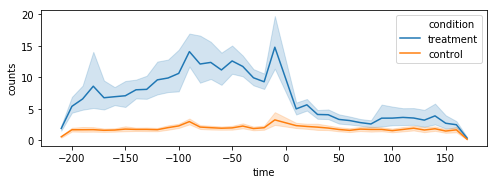

In [3]:
# this may take a minute
_,ax = plt.subplots(1,1,figsize=[8,2.5])
sns.lineplot(data=df,x='time',y='counts',hue='condition',ax=ax);

- The treatment group seems to experience a significant decrease in hate speech at around $t=0$.
- The control group seems relatively unaffected.
- Let's try to quantify these observations.

# Variable intercept model

In the variable intercept model, we associate an additional coefficient with the post-treatment period. Formally:

\begin{equation}
y_{t,i} \sim f( \exp (\mathbf{\beta} \cdot \mathbf{x}_{t,i} + \gamma \delta(t > \tau))),
\end{equation}
- $y_{t,i}$ is the outcome for individual $i$ at time $t$
- $\mathbf{x}_{t,i}$ is a vector of covariates, and $\mathbf{\beta}$ is a vector of parameters
- $\delta(t > \tau)$ indicates whether $t$ is in the post-treatment period
- $\gamma$ quantifies the causal impact of the treatment on the intercept
- $f$ specifies a **distribution**, such as the Normal or Poisson

## Implementation

- In this case, we set $x_{t,i} = [t]$, which allows the model to correct for a linear trend in the data.
- It might be nice to include a user-level covariate, but this poses memory challenges for `statsmodels`.
- Since the underlying data is counts, we will use Poisson regression.

In [4]:
df['post_treatment'] = df['time'] > 0

In [5]:
df_treat = df.loc[df['condition']=='treatment'].copy()
df_control = df.loc[df['condition']=='control'].copy()

In [6]:
model = smf.poisson('counts ~ time + post_treatment',data = df_treat)
results = model.fit()

Optimization terminated successfully.
         Current function value: 18.643179
         Iterations 6


In [7]:
print(results.summary2())

                            Results: Poisson
Model:                 Poisson           Pseudo R-squared:  0.041       
Dependent Variable:    counts            AIC:               4324328.7106
Date:                  2019-06-01 19:30  BIC:               4324357.6940
No. Observations:      115976            Log-Likelihood:    -2.1622e+06 
Df Model:              2                 LL-Null:           -2.2548e+06 
Df Residuals:          115973            LLR p-value:       0.0000      
Converged:             1.0000            Scale:             1.0000      
No. Iterations:        6.0000                                           
------------------------------------------------------------------------
                        Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------
Intercept               2.5721   0.0022 1143.9333 0.0000  2.5677  2.5765
post_treatment[T.True] -1.6447   0.0047 -350.9292 0.0000 -1.6539 -1.6356
time  

These results say:
- For each individual in the treatment group, the base rate of hate speech lexicon matches is $e^{2.6} = 13$ per $10$ days.
- There is a discontinuity in the post-treatment period, with a decrease in the rate of hate speech by $e^{-1.3} = 80\%$.
- There is a slightly increasing trend of $e^{0.0032} = 0.3\%$ more hate speech words per day overall.

### Model fit

In [8]:
# fitted values
df_treat['fit'] = np.exp(results.fittedvalues)

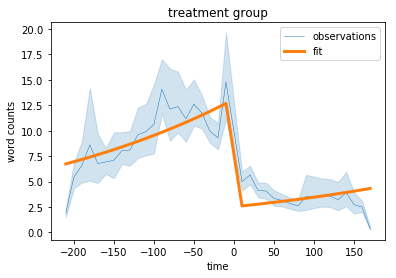

In [9]:
ax = sns.lineplot(data=df_treat,x='time',y='counts',linewidth=0.5)
ax = sns.lineplot(data=df_treat,x='time',y='fit', ax = ax, linewidth=3)
ax.set_title('treatment group')
plt.legend(['observations','fit'])
ax.set_ylabel('word counts');

### Control group

Now let's see what the same model says about the control group

In [10]:
model_control = smf.poisson('counts ~ time + post_treatment',data = df_control)
results_control = model_control.fit()

Optimization terminated successfully.
         Current function value: 4.884093
         Iterations 4


In [11]:
print(results_control.summary2())

                           Results: Poisson
Model:                Poisson           Pseudo R-squared:  0.001       
Dependent Variable:   counts            AIC:               1149965.7242
Date:                 2019-06-01 19:30  BIC:               1149994.7526
No. Observations:     117725            Log-Likelihood:    -5.7498e+05 
Df Model:             2                 LL-Null:           -5.7575e+05 
Df Residuals:         117722            LLR p-value:       0.0000      
Converged:            1.0000            Scale:             1.0000      
No. Iterations:       4.0000                                           
-----------------------------------------------------------------------
                        Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
Intercept               0.7839   0.0048 161.7137 0.0000  0.7744  0.7934
post_treatment[T.True] -0.3361   0.0087 -38.5147 0.0000 -0.3532 -0.3190
time                

This suggests that the intervention had an effect on the control group, albeit a weaker effect than on the treatment group: a reduction by 30\%. 

This is not inconceivable, since the intervention could have discouraged hate speech throughout the site, even for individuals who were not directly affected.

### Visualization of model fit on control

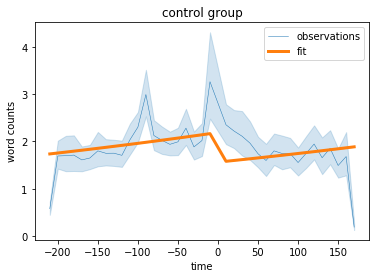

In [12]:
df_control['fit'] = np.exp(results_control.fittedvalues)
ax = sns.lineplot(data=df_control,x='time',y='counts',linewidth=0.5)
ax = sns.lineplot(data=df_control,x='time',y='fit', ax = ax, linewidth=3)
ax.set_title('control group')
plt.legend(['observations','fit'])
ax.set_ylabel('word counts');

## Combined model

To differentiate between the direct effect on the treated group (of having "echo chamber" forums closed) from the indirect effect on the control group (of hate speech being generally discouraged), we can model both groups together, using the following formula:

``` counts ~ time + post_treatment * condition```

This specifies an **interaction effect** between the treatment group and the post-treatment period. Coefficients are estimated for all but one of the combinations of these two variables.

In [13]:
model_combined = smf.poisson('counts ~ time + post_treatment * condition',
                            data = df)
results_combined = model_combined.fit()

Optimization terminated successfully.
         Current function value: 11.717176
         Iterations 6


In [14]:
print(results_combined.summary2())

                                       Results: Poisson
Model:                        Poisson                   Pseudo R-squared:          0.093       
Dependent Variable:           counts                    AIC:                       5476641.3888
Date:                         2019-06-01 19:30          BIC:                       5476693.1978
No. Observations:             233701                    Log-Likelihood:            -2.7383e+06 
Df Model:                     4                         LL-Null:                   -3.0189e+06 
Df Residuals:                 233696                    LLR p-value:               0.0000      
Converged:                    1.0000                    Scale:                     1.0000      
No. Iterations:               6.0000                                                           
-----------------------------------------------------------------------------------------------
                                               Coef.  Std.Err.     z     P>|z|  

The combined model shows that:

- Control users produce half as many hate speech words per 10 days after the treatment.
- Treatment users produce 80\% fewer fewer hate speech words after the treatment.
- The treatment users produce $4.8$ times more hate speech words overall.

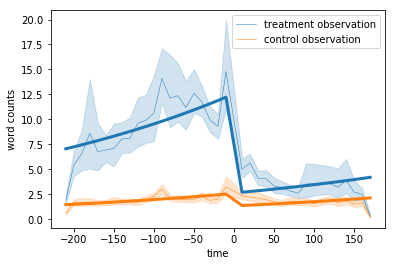

In [15]:
df['fit'] = np.exp(results_combined.fittedvalues)
ax = sns.lineplot(data=df,x='time',y='counts',hue='condition',linewidth=0.5)
ax = sns.lineplot(data=df,x='time',y='fit',hue='condition',ax = ax, linewidth=3)
plt.legend(['treatment observation','control observation'])
ax.set_ylabel('word counts');

## Variable slopes model

In some cases, the treatment affects not only the intercept, but also the slope. We can model this possibility as follows:

\begin{equation}
y_{t,i} \sim f(\mathbf{\beta} \cdot \mathbf{x}_{t,i} + \gamma \delta(t > \tau) + \rho t \delta(t > \tau)),
\end{equation}
where $\rho$ quantifies the effect of the treatment on the slope.

In [16]:
formula = 'counts ~ time + post_treatment * condition + post_treatment * condition * time'
model_slopes = smf.poisson(formula, data = df)
results_slopes = model_slopes.fit()

Optimization terminated successfully.
         Current function value: 11.642199
         Iterations 7


In [17]:
print(results_slopes.summary2())

                                         Results: Poisson
Model:                          Poisson                    Pseudo R-squared:           0.099       
Dependent Variable:             counts                     AIC:                        5441603.1079
Date:                           2019-06-01 19:31           BIC:                        5441686.0023
No. Observations:               233701                     Log-Likelihood:             -2.7208e+06 
Df Model:                       7                          LL-Null:                    -3.0189e+06 
Df Residuals:                   233693                     LLR p-value:                0.0000      
Converged:                      1.0000                     Scale:                      1.0000      
No. Iterations:                 7.0000                                                             
---------------------------------------------------------------------------------------------------
                                          

- There is a negative coefficient for the interaction of the post_treatment period and the time.
- This coefficient is even larger for the treatment group.
- Because the magnitude of this coefficient is larger than the positive `time` coefficient alone, this indicates a reversal of slope.
- The fit of this model is slightly better than the variable intercept model:
    - $r^2 = 0.099$ versus $0.093$
    - $AIC = 5441603$  versus $5476641$

#### Visualizing model fit

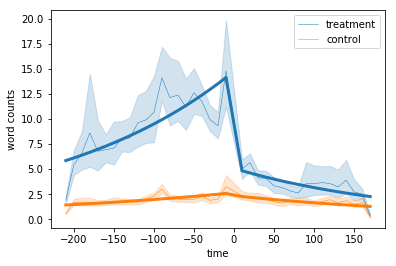

In [18]:
df['fit'] = np.exp(results_slopes.fittedvalues)
ax = sns.lineplot(data=df,x='time',y='counts',hue='condition',linewidth=0.5)
ax = sns.lineplot(data=df,x='time',y='fit',hue='condition',ax = ax, linewidth=3)
plt.legend(['treatment','control'])
ax.set_ylabel('word counts');

# Next steps

- For an alternative robustness check, randomly select other times as the beginning of the post-treatment period, and re-run the analysis. The estimated treatment effect should be smaller.
- Compute the residuals, $y_{t,i} - \hat{y}_{t,i}$, where $\hat{y}_{t,i}$ is the model prediction.
- Scatter plot the residuals against the true values, and see how the error distribution changes. 
    - In a Poisson distribution, the variance grows with the expected value, and so we would expect to see the residuals grow linearly.
    - You will find that some of the residuals are much larger than this!